In [3]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from numpy import array

In [4]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('ADBE.csv')
df1=df.reset_index()['Close']

In [5]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [6]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [7]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [8]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 30
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [9]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
# X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
# X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
# X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

if len(X_train.shape) == 2:
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
if len(X_test.shape) == 2:
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
if len(X_val.shape) == 2:
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

In [10]:
from tensorflow.keras.layers import RNN, SimpleRNNCell
from tensorflow.keras.initializers import glorot_uniform

class AdditiveRNNCell(SimpleRNNCell):
    def build(self, input_shape):
        super().build(input_shape)
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer=glorot_uniform(),
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(shape=(self.units, self.units),
                                                initializer=glorot_uniform(),
                                                name='recurrent_kernel')
        self.bias = self.add_weight(shape=(self.units,),
                                    initializer='zeros',
                                    name='bias')
        self.built = True

    def __call__(self, inputs, states, training=None):
        prev_output = states[0]
        h = prev_output + self.activation(tf.matmul(inputs, self.kernel) + tf.matmul(prev_output, self.recurrent_kernel) + self.bias)
        return h, [h]

In [11]:
# Xây dựng model AddRNN
inputs = Input(shape=(time_step, 1))
x = RNN(AdditiveRNNCell(50), return_sequences=False)(inputs)  # 50 units
outputs = Dense(1)(x)

model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 30, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rnn (RNN)                       │ (None, 50)             │         5,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,251 (20.51 KB)

 Trainable params: 5,251 (20.51 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100


c:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:664: UserWarning: Gradients do not exist for variables ['kernel', 'recurrent_kernel', 'bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 40.4681 - val_loss: 7.5202
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.0675 - val_loss: 2.7945
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 10.0343 - val_loss: 1.7756
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.1056 - val_loss: 0.6196
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.5074 - val_loss: 0.1385
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.2137 - val_loss: 0.1283
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1335 - val_loss: 0.0954
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1291 - val_loss: 0.1386
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1004 - val_loss: 0.1383
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0897 - val_loss: 0.1038
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0687 - val_loss: 0.1110
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0679 

In [13]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [14]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [15]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

Validation RMSE: 584.9494334226141
Testing RMSE: 437.05497655043223


In [16]:
# Dự báo 30 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

lst30_output = []
n_steps = time_step
i = 0
while i < 30:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))

    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst30_output.extend(yhat.tolist())
    i += 1

# Chuyển đổi giá trị dự đoán về phạm vi ban đầu
lst30_output = scaler.inverse_transform(lst30_output)

# In giá trị dự đoán
print("Dự báo 30 ngày tiếp theo:", lst30_output)

Dự báo 30 ngày tiếp theo: [[609.71962029]
 [555.54370807]
 [508.43201999]
 [497.16106789]
 [484.50772315]
 [452.23103243]
 [422.51398442]
 [413.26685412]
 [437.96107531]
 [473.84392793]
 [502.10713102]
 [554.30269502]
 [577.25669361]
 [596.24464556]
 [628.90121318]
 [624.59885369]
 [591.83031963]
 [574.23561579]
 [588.86863675]
 [601.45534958]
 [614.94234287]
 [636.30268065]
 [630.10079451]
 [618.07202709]
 [596.20065505]
 [568.6841275 ]
 [548.25537012]
 [531.37710158]
 [483.07402548]
 [379.41189411]]


In [17]:
# Dự báo 60 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

lst60_output = []
n_steps = time_step
i = 0
while i < 60:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))

    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst60_output.extend(yhat.tolist())
    i += 1

# Chuyển đổi giá trị dự đoán về phạm vi ban đầu
lst60_output = scaler.inverse_transform(lst60_output)

# In giá trị dự đoán
print("Dự báo 30 ngày tiếp theo:", lst60_output)

Dự báo 30 ngày tiếp theo: [[ 609.71962029]
 [ 555.54370807]
 [ 508.43201999]
 [ 497.16106789]
 [ 484.50772315]
 [ 452.23103243]
 [ 422.51398442]
 [ 413.26685412]
 [ 437.96107531]
 [ 473.84392793]
 [ 502.10713102]
 [ 554.30269502]
 [ 577.25669361]
 [ 596.24464556]
 [ 628.90121318]
 [ 624.59885369]
 [ 591.83031963]
 [ 574.23561579]
 [ 588.86863675]
 [ 601.45534958]
 [ 614.94234287]
 [ 636.30268065]
 [ 630.10079451]
 [ 618.07202709]
 [ 596.20065505]
 [ 568.6841275 ]
 [ 548.25537012]
 [ 531.37710158]
 [ 483.07402548]
 [ 379.41189411]
 [ 130.37337435]
 [ 391.0030697 ]
 [ 461.21984127]
 [ 482.33916173]
 [ 465.36833737]
 [ 403.59270316]
 [ 268.82461786]
 [ 252.63700974]
 [ 357.22428537]
 [ 419.82341696]
 [ 478.11012836]
 [ 633.85991517]
 [ 698.35216997]
 [ 702.9444481 ]
 [ 690.63310241]
 [ 686.57186363]
 [ 651.43091789]
 [ 629.88836326]
 [ 627.72104246]
 [ 574.45737757]
 [ 502.05440444]
 [ 475.52706884]
 [ 435.55519259]
 [ 370.11839543]
 [ 177.96091332]
 [-170.61082679]
 [ 105.5473238 ]
 [ 16

In [18]:
# Dự báo 90 ngày tiếp theo
x_input = test_data[-time_step:].reshape(1, -1)
temp_input = list(x_input[0])

lst90_output = []
n_steps = time_step
i = 0
while i < 90:
    if len(temp_input) > n_steps:
        x_input = np.array(temp_input[-n_steps:])
        x_input = x_input.reshape((1, n_steps, 1))
    else:
        x_input = np.array(temp_input).reshape((1, len(temp_input), 1))

    yhat = model.predict(x_input, verbose=0)
    temp_input.extend(yhat[0].tolist())
    lst90_output.extend(yhat.tolist())
    i += 1

# Chuyển đổi giá trị dự đoán về phạm vi ban đầu
lst90_output = scaler.inverse_transform(lst90_output)

# In giá trị dự đoán
print("Dự báo 30 ngày tiếp theo:", lst90_output)

Dự báo 30 ngày tiếp theo: [[ 6.09719620e+02]
 [ 5.55543708e+02]
 [ 5.08432020e+02]
 [ 4.97161068e+02]
 [ 4.84507723e+02]
 [ 4.52231032e+02]
 [ 4.22513984e+02]
 [ 4.13266854e+02]
 [ 4.37961075e+02]
 [ 4.73843928e+02]
 [ 5.02107131e+02]
 [ 5.54302695e+02]
 [ 5.77256694e+02]
 [ 5.96244646e+02]
 [ 6.28901213e+02]
 [ 6.24598854e+02]
 [ 5.91830320e+02]
 [ 5.74235616e+02]
 [ 5.88868637e+02]
 [ 6.01455350e+02]
 [ 6.14942343e+02]
 [ 6.36302681e+02]
 [ 6.30100795e+02]
 [ 6.18072027e+02]
 [ 5.96200655e+02]
 [ 5.68684127e+02]
 [ 5.48255370e+02]
 [ 5.31377102e+02]
 [ 4.83074025e+02]
 [ 3.79411894e+02]
 [ 1.30373374e+02]
 [ 3.91003070e+02]
 [ 4.61219841e+02]
 [ 4.82339162e+02]
 [ 4.65368337e+02]
 [ 4.03592703e+02]
 [ 2.68824618e+02]
 [ 2.52637010e+02]
 [ 3.57224285e+02]
 [ 4.19823417e+02]
 [ 4.78110128e+02]
 [ 6.33859915e+02]
 [ 6.98352170e+02]
 [ 7.02944448e+02]
 [ 6.90633102e+02]
 [ 6.86571864e+02]
 [ 6.51430918e+02]
 [ 6.29888363e+02]
 [ 6.27721042e+02]
 [ 5.74457378e+02]
 [ 5.02054404e+02]
 [ 4.

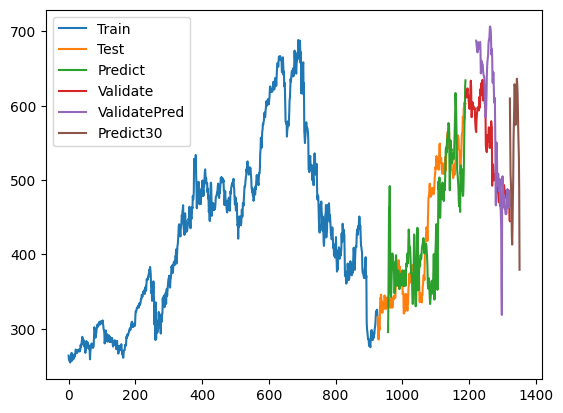

In [20]:
# 14.Vẽ hình
# plt.plot(pd.index, scaler.inverse_transform(train_data), label='Train')
# plt.plot(pd.index[:train_size - time_step -1], train_predict, label='Train Predict')
# plt.plot(pd.index[train_size + time_step: -1], y_pred, label='Test Predict')
# plt.legend()
# plt.show()


train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+31, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+31, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect30_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1) +29, step=1)
plt.plot(prediect30_data_index,(lst30_output))

# prediect60_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+59, step=1)
# plt.plot(prediect60_data_index,scaler.inverse_transform(lst60_output))

# prediect90_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+89, step=1)
# plt.plot(prediect90_data_index,scaler.inverse_transform(lst90_output))

plt.legend(['Train','Test','Predict','Validate','ValidatePred', 'Predict30'])
plt.show()